<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/Supervised_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning: Clock Drawing Image Classification with Convolutional Neural Networks
### Stacey Beck and Ian Byrne

- Split data into sets of Training (x = image arrays ; y = labels), Test (~10% image arrays), and Validation (~10% of the Training). 
- Build CNN using Pytorch for Training and Test:
  - Specify CUDA
  - 2D convolution, Normalization (for faster training), Non-linear Activation Function (ex. RELU), Max Pooling (downsampling to reduce learned parameters).
  - Define Layers 
  - Build Forward and backward pass
  - Define optimizer (due to many - deep - nodes) ex) ADAM
  - Calculate Loss (BCE)
  - Calculate Accuracy, Precision, Recall (Confusion Matrix)
  - Plot ROC and print Confusion Matrix



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
#!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 586, done.
remote: Counting objects: 100% (586/586), done.
remote: Compressing objects: 100% (485/485), done.
remote: Total 586 (delta 322), reused 219 (delta 92), pack-reused 0
Receiving objects: 100% (586/586), 4.49 MiB | 5.20 MiB/s, done.
Resolving deltas: 100% (322/322), done.
/content/MADSmilestone2


In [3]:
!pip install torchmetrics

# General Libraries
import pandas as pd
import numpy as np

# Custom Libraries
import Loading.load_data as ld
import ImagePlayground.Images

# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# To Evaluate model
from tqdm import tqdm
import torchmetrics
from torchmetrics import ConfusionMatrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To visualize model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.io import imread

# To split the data
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 282 kB 16.2 MB/s 


In [ ]:
#!rm -rf /content/MADSmilestone2

# Build CNN Model using Pytorch


### Building and Training
Architecture choices influenced from: 

https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/

https://medium.datadriveninvestor.com/five-powerful-cnn-architectures-b939c9ddd57b

https://towardsdatascience.com/how-does-sparse-convolution-work-3257a0a8fd1

In [4]:
# Define some of the hyperparameters and training variables
#epochs = 2
#batch_size = 25
learning_rate = 1e-3
kernel_size = 3
stride = 1
padding = 1 #2*floor(3/2)

accuracy_stats = {
    'train': [],
    'val': []
}

loss_stats = {
    'train': [],
    'val': []
}
#activation function

In [5]:
# Load numpy array files, add dimension of 1 for gray scale, and zip images and labels 
# get zipped im label and separate label tensors
tr_im_path = "Dementia_label_data/balanced_training.npy"
tr_lb_path = "Dementia_label_data/balanced_train_labels.npy"
val_im_path = "Dementia_label_data/val_im_nobal.npy"
val_lb_path = "Dementia_label_data/val_labels_im_nobal.npy"
tst_im_path = "Dementia_label_data/test_im_nobal.npy"
tst_lb_path = "Dementia_label_data/val_labels_im_nobal.npy"

training_data, y_train_tensor = ld.load_np_files(tr_im_path, tr_lb_path)
validation_data, y_val_tensor = ld.load_np_files(val_im_path, val_lb_path)
test_data, y_test_tensor = ld.load_np_files(tst_im_path, tst_lb_path)


(23535, 1, 368, 284)
(2544, 1, 368, 284)
(2541, 1, 368, 284)


In [6]:
# Get image data and label tensors
train_loader = torch.utils.data.DataLoader(training_data, batch_size = 64, shuffle = True, num_workers = 6) 
validate_loader = torch.utils.data.DataLoader(validation_data, batch_size = 8, shuffle = False, num_workers = 6) #64, 8, 1
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1, shuffle = False)


#Labels 
classes = (0, 1, 2)

torch.LongTensor
torch.Size([4, 1, 368, 284])


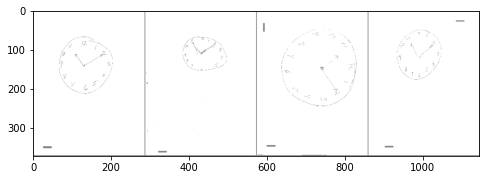

Labels:
    2              2              0              0


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
#print(images.size())
print(images.type())
#images = images.unsqueeze(1)
print(images.size())
# show images
imshow(torchvision.utils.make_grid(images, nrow = 4))
# print labels
print('Labels:')
print('          '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

#Printing as RGB, just using basic pytorch dataloader likely converting to rbg

In [7]:
# Set to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.backends.cudnn.benchmark = True




class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # without considering batch size: Input shape : (None,368, 284, 1) , parameters: (3*3*1*16+16) = 160
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, # one input channel gray scale, 16 filters out
                            kernel_size = 3, stride = 1, padding = 1) #Out:(None,386, 284, 16)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640                        
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 184, 142, 32)
    self.bn1 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640    
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248                     
    self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 92, 71, 64)
    self.bn2 = nn.BatchNorm2d(64) 

    self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248 
    self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 128, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248
    self.pool3 = nn.MaxPool2d(2, 2) #Output shape = (None, 46, 35, 128)
    self.bn3 = nn.BatchNorm2d(128)

                             
    # Fully connected layer
    self.fc1 = nn.Linear(128*46*35,3)
    #self.fc2 = nn.Linear(120, 60)
    #self.fc3 = nn.Linear(60, 30)
    #self.fc4 = nn.Linear(30, 3) # left with 3 for the three classes                     



  def forward(self, x):
    x = self.bn1(self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))))
    x = self.bn2(self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))))
    x = self.bn3(self.pool3(F.relu(self.conv6(F.relu(self.conv5(x))))))
    x = x.view(x.size(0),128*46*35)
    x = self.fc1(x)


    return x                        
    




# Create model object 
model = ConvNet()
if torch.cuda.is_available():
    model = model.to(float).cuda()
    print('Model training on GPU')
else:
    print("CUDA is not available. Training on CPU...")

#for param in model.parameters():
  #print(str(param.data.numpy().shape)+'\n')
  #print("weights fc1: ", model.fc1.weight)

# Loss function
criterion = nn.CrossEntropyLoss(reduction="mean")

# Optimizer (can use SGD or ADAM)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)#, momentum = 0.9) #or ADAM/ momentum
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9) #or ADAM/ momentum


print(model)






def train_val_model(epochs):
  for epoch in range(1, epochs + 1):

    # TRAINING ********************************
    train_epoch_loss = 0
    train_epoch_acc = 0

    # set model in training mode (recommended)
    model.train()

    
    # Double check
    tr_run_loss=0
    tr_correct=0
    tr_total=0
    train_accu = []
    train_losses = []
    
    print('\nEpoch$ : %d'%epoch)
    for x_train_batch, y_train_batch in tqdm(train_loader):
      x_train_batch = x_train_batch.to(float).to(device) # for GPU support
      y_train_batch = y_train_batch.to(device) 

      #print(x_train_batch.shape)

      # sets gradients to 0 to prevent interference with previous epoch
      optimizer.zero_grad()

      # Forward pass through NN
      y_train_pred = model(x_train_batch)#.to(float))
      train_loss = criterion(y_train_pred, y_train_batch)
      train_acc = accuracy(y_train_pred, y_train_batch)

      # Backward pass, updating weights
      train_loss.backward()
      optimizer.step()

      # Statistics
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()

      # Double check scores
      tr_run_loss += train_loss.item()
     
      _, predicted = y_train_pred.max(1)
      tr_total += y_train_batch.size(0)
      tr_correct += predicted.eq(y_train_batch).sum().item()
       
    tr_loss = tr_run_loss/len(train_loader)
    accu = 100.*tr_correct/tr_total
   
    train_accu.append(accu)
    train_losses.append(tr_loss)
    print('Train Loss: %.3f | Train Accuracy: %.3f'%(tr_loss,accu))



    # VALIDATION****************************************   
    
    with torch.set_grad_enabled(False):
      val_epoch_loss = 0
      val_epoch_acc = 0

      # Double check
      val_run_loss=0
      val_correct=0
      val_total=0
      val_accu = []
      val_losses = []


      model.eval()
      for x_val_batch, y_val_batch in validate_loader:
      
        x_val_batch =  x_val_batch.to(float).to(device)
        y_val_batch = y_val_batch.to(device)
            
        # Forward pass
        y_val_pred = model(x_val_batch)   
        val_loss = criterion(y_val_pred, y_val_batch)
        val_acc = accuracy(y_val_pred, y_val_batch)
            
        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc.item()

        # Double check
        
        val_run_loss += val_loss.item()
     
        _, predictedv = y_val_pred.max(1)
        val_total += y_train_batch.size(0)
        val_correct += predictedv.eq(y_val_batch).sum().item()
       
      vl_loss = val_run_loss/len(validate_loader)
      accuv = 100.*val_correct/val_total
   
      val_accu.append(accuv)
      val_losses.append(vl_loss)
      print('Validation Loss: %.3f | Validation Accuracy: %.3f'%(vl_loss,accuv))


    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(validate_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(validate_loader))
                              
    
    print(f'Epoch {epoch+0:03}: Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(validate_loader):.5f}') 
    print(f'Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(validate_loader):.3f}')

      # Forward pass through NN
      #outputs = model(images.to(float))
      #loss = criterion(outputs, labels)

      # Backward pass, updating weights
      #loss.backward()
      #optimizer.step()
      #print(model.fc1.weight.detach().numpy())

      # Statistics 
      #running_loss += loss.item()
      # Track every 100th loss:
      #if i % 100 == 0:
        #losses.append(loss.item())
        #num_times = num_times + 1

      # print every 500th batch
      #if i % 500 == 0:
        #print("epoch: {} loss: {}".format(i, loss))
        #print('[%d %d] loss %.4f'% (epoch + 1, i + 1, running_loss/500))
        #running_loss = 0.0

    #print("\nFinished training Epoch {}\n".format(epoch + 1))
  

    # Plot the loss
    #plt.plot([i for i in range(num_times)],losses, label = 'epoch' + str(epoch))
    #plt.legend(loc = 1, mode = 'expanded', shadow = True, ncol = 2)
  #plt.show()

  #los_chart(losses)






"""
def los_chart(losses):
  plt.plot(losses)
  plt.title('loss vs epochs')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.show()
"""







def accuracy(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_prob = torch.max(y_pred_softmax, dim = 1)
  
  #y_preds = y_pred.argmax(dim=1)

  correct_pred = (y_pred_prob == y_test).float()
  #print("correct sum: ", correct_pred.sum())
  #print('correct total length: ', len(correct_pred))
  #print(correct_pred)
  acc = correct_pred.sum() / len(correct_pred)
  
  #acc = correct_pred.sum().float() / float( y_test.size(0) )

  acc = torch.round(acc * 100)

  return acc



  """
  model.eval()
  # Calculate performance
  correct = 0
  total = 0
  accuracy = 0
  with torch.set_grad_enabled(False):
      #model.to(float)
      for batches in test_loader:
        x_test, y_test = batches
        x_test = x_test.to(float).to(device)
        y_test = y_test.to(float).to(device)
        y_pred = model(x_test)
        _,y_pred = torch.max(y_pred.data, 1)# returns strongest label val and index
        total += y_test.size(0)
        #print(y_pred.size())
        #print(y_test.size())
      
        correct += (y_pred == y_test).sum().item()
        accuracy = (correct/total) * 100
      
      
      print('Accuracy = '+str(accuracy))"""


"""# TESTING****************************************   
    with torch.set_grad_enabled(False):
        
        tst_epoch_loss = 0
        tst_epoch_acc = 0
        
        model.eval()
        for x_tst_batch, y_tst_batch in test_loader:
            x_tst_batch = x_tst_batch.to(float).to(device) # for GPU support
            y_tst_batch = y_tst_batch.to(device)
            
            # Forward pass
            y_tst_pred = model(x_tst_batch)
            tst_loss = criterion(y_tst_pred, y_tst_batch)
            tst_acc = accuracy(y_tst_pred, y_tst_batch)
            
            tst_epoch_loss += tst_loss.item()
            tst_epoch_acc += tst_acc.item()"""












if __name__ == '__main__':
  train_val_model(20)













Model training on GPU
ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

  0%|          | 0/368 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 4.197 | Train Accuracy: 39.099


Validation Loss: 1.578 | Validation Accuracy: 8.531
Epoch 001: Train Loss: 4.19721 | Val Loss: 1.57792
Train Acc: 39.193 | Val Acc: 50.135

Epoch$ : 2


100%|██████████| 368/368 [03:28<00:00,  1.77it/s]

Train Loss: 1.381 | Train Accuracy: 47.674


Validation Loss: 1.333 | Validation Accuracy: 6.985
Epoch 002: Train Loss: 1.38105 | Val Loss: 1.33286
Train Acc: 47.674 | Val Acc: 41.069

Epoch$ : 3


100%|██████████| 368/368 [03:27<00:00,  1.77it/s]

Train Loss: 0.970 | Train Accuracy: 55.653


Validation Loss: 1.213 | Validation Accuracy: 7.280
Epoch 003: Train Loss: 0.97035 | Val Loss: 1.21255
Train Acc: 55.620 | Val Acc: 42.777

Epoch$ : 4


100%|██████████| 368/368 [03:28<00:00,  1.77it/s]

Train Loss: 0.846 | Train Accuracy: 61.411


Validation Loss: 1.127 | Validation Accuracy: 8.176
Epoch 004: Train Loss: 0.84638 | Val Loss: 1.12676
Train Acc: 61.370 | Val Acc: 48.028

Epoch$ : 5


100%|██████████| 368/368 [03:28<00:00,  1.77it/s]

Train Loss: 0.759 | Train Accuracy: 66.735


Validation Loss: 1.249 | Validation Accuracy: 7.166
Epoch 005: Train Loss: 0.75932 | Val Loss: 1.24861
Train Acc: 66.696 | Val Acc: 42.160

Epoch$ : 6


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.703 | Train Accuracy: 70.070


Validation Loss: 1.186 | Validation Accuracy: 8.136
Epoch 006: Train Loss: 0.70280 | Val Loss: 1.18615
Train Acc: 70.049 | Val Acc: 47.836

Epoch$ : 7


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.654 | Train Accuracy: 72.390


Validation Loss: 1.174 | Validation Accuracy: 8.363
Epoch 007: Train Loss: 0.65362 | Val Loss: 1.17404
Train Acc: 72.386 | Val Acc: 49.157

Epoch$ : 8


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.605 | Train Accuracy: 75.007


Validation Loss: 1.566 | Validation Accuracy: 6.316
Epoch 008: Train Loss: 0.60498 | Val Loss: 1.56606
Train Acc: 75.011 | Val Acc: 37.138

Epoch$ : 9


100%|██████████| 368/368 [03:28<00:00,  1.77it/s]

Train Loss: 0.562 | Train Accuracy: 77.455


Validation Loss: 1.329 | Validation Accuracy: 7.828
Epoch 009: Train Loss: 0.56159 | Val Loss: 1.32912
Train Acc: 77.478 | Val Acc: 46.031

Epoch$ : 10


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.525 | Train Accuracy: 79.091


Validation Loss: 1.998 | Validation Accuracy: 5.540
Epoch 010: Train Loss: 0.52540 | Val Loss: 1.99819
Train Acc: 79.114 | Val Acc: 32.553

Epoch$ : 11


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.484 | Train Accuracy: 80.854


Validation Loss: 1.503 | Validation Accuracy: 7.607
Epoch 011: Train Loss: 0.48370 | Val Loss: 1.50300
Train Acc: 80.897 | Val Acc: 44.730

Epoch$ : 12


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.441 | Train Accuracy: 82.787


Validation Loss: 1.575 | Validation Accuracy: 7.634
Epoch 012: Train Loss: 0.44135 | Val Loss: 1.57520
Train Acc: 82.832 | Val Acc: 44.877

Epoch$ : 13


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.402 | Train Accuracy: 84.695


Validation Loss: 1.555 | Validation Accuracy: 8.731
Epoch 013: Train Loss: 0.40176 | Val Loss: 1.55471
Train Acc: 84.755 | Val Acc: 51.292

Epoch$ : 14


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.361 | Train Accuracy: 86.492


Validation Loss: 1.750 | Validation Accuracy: 7.842
Epoch 014: Train Loss: 0.36119 | Val Loss: 1.75017
Train Acc: 86.568 | Val Acc: 46.094

Epoch$ : 15


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.322 | Train Accuracy: 88.209


Validation Loss: 2.005 | Validation Accuracy: 7.333
Epoch 015: Train Loss: 0.32169 | Val Loss: 2.00457
Train Acc: 88.291 | Val Acc: 43.123

Epoch$ : 16


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.288 | Train Accuracy: 89.747


Validation Loss: 2.039 | Validation Accuracy: 7.601
Epoch 016: Train Loss: 0.28821 | Val Loss: 2.03878
Train Acc: 89.802 | Val Acc: 44.679

Epoch$ : 17


100%|██████████| 368/368 [03:29<00:00,  1.75it/s]

Train Loss: 0.266 | Train Accuracy: 90.571


Validation Loss: 2.426 | Validation Accuracy: 6.818
Epoch 017: Train Loss: 0.26573 | Val Loss: 2.42622
Train Acc: 90.620 | Val Acc: 40.079

Epoch$ : 18


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.242 | Train Accuracy: 91.332


Validation Loss: 2.451 | Validation Accuracy: 7.373
Epoch 018: Train Loss: 0.24212 | Val Loss: 2.45140
Train Acc: 91.356 | Val Acc: 43.333

Epoch$ : 19


100%|██████████| 368/368 [03:29<00:00,  1.75it/s]

Train Loss: 0.201 | Train Accuracy: 93.219


Validation Loss: 2.242 | Validation Accuracy: 7.594
Epoch 019: Train Loss: 0.20073 | Val Loss: 2.24185
Train Acc: 93.223 | Val Acc: 44.651

Epoch$ : 20


100%|██████████| 368/368 [03:29<00:00,  1.76it/s]

Train Loss: 0.168 | Train Accuracy: 94.468


Validation Loss: 2.830 | Validation Accuracy: 7.126
Epoch 020: Train Loss: 0.16839 | Val Loss: 2.83048
Train Acc: 94.424 | Val Acc: 41.947


# Visualize the Training and Validation


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

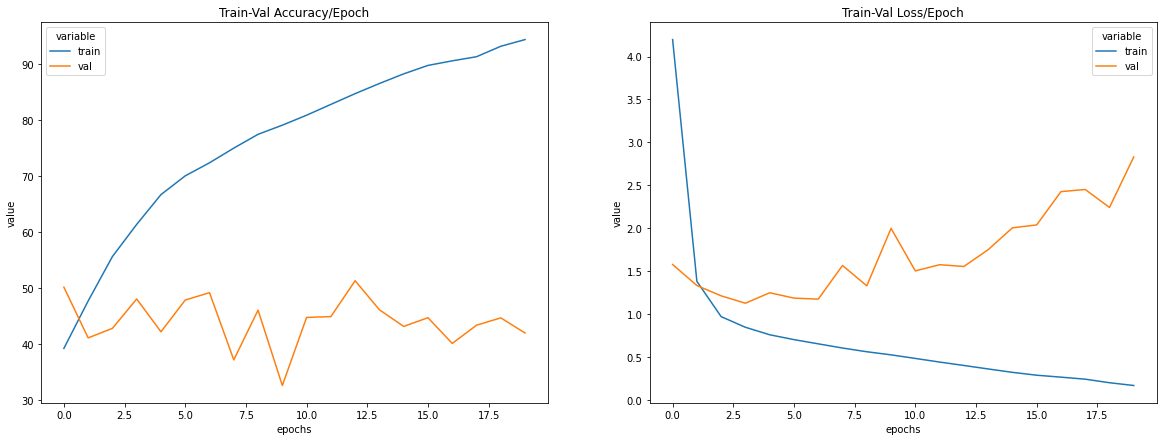

In [8]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_acc_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/acc.csv', index = False)
train_val_loss_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/loss.csv', index = False)
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

# Evaluate the model using Test Set

In [12]:
all_pred = []
all_preds = torch.tensor([])
y_test = torch.tensor([])
with torch.set_grad_enabled(False):
  model.eval()
  for x_test_batch, y_test_batch in test_loader:
    x_test_batch = x_test_batch.to(float).to(device)
    y_test_pred = model(x_test_batch)
    _, y_pred_probs = torch.max(y_test_pred, dim = 1)
    all_pred.append(y_pred_probs.cpu().numpy())
    all_preds = torch.cat((all_preds.cpu(), y_pred_probs.cpu()),dim = 0)
    y_test = torch.cat((y_test, y_test_batch), dim = 0) 

#all_preds = [a.squeeze().tolist() for a in all_preds]

## Create Confusion Matrix

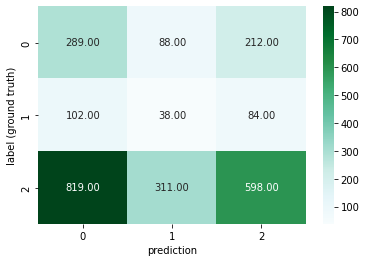

In [13]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, all_pred))#.rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [14]:
"""def conf_matrix(model, loader):
  model.eval()
  all_preds = torch.tensor([])
  with torch.set_grad_enabled(False):
    for batch in loader:
      x_test, y_test = batch
      x_test = x_test.to(float).to(device)
      y_test = y_test.to(float).to(device)
      preds = model(x_test)
      # concatenates all predictions per batch into one list
      all_preds = torch.cat((all_preds.cpu(), preds.cpu()),dim = 0) 
  
  print(all_preds.size())
  print(y_test_tensor.size())
  print(y_test.size())
  print(y_train_tensor.size())
  return all_preds"""






def plot_conf_matrix(matrix, class_names, session):
  df_cm = pd.DataFrame(matrix, class_names, class_names) #matrix.numpy()
  df_cm.to_csv("/content/gdrive/MyDrive/Colab Notebooks/model_charts/conf_matrix_{}".format(session))
  plt.figure(figsize = (9,6))
  sns.heatmap(df_cm, annot=True, fmt=".2f", cmap='BuGn')
  plt.xlabel("prediction")
  plt.ylabel("label (ground truth)")
  plt.show()






from sklearn.metrics import classification_report, confusion_matrix
#all_pred = conf_matrix(model, train_loader)
#confmat = ConfusionMatrix(num_classes = 3)
#cmtx = confmat(y_train_tensor.cpu().numpy(), all_preds)
#cmtx = confmat(y_test, all_pred)
class_names = ["Possible Dementia", "Likely Dementia", "No Dementia"]
class_vals = [0,1,2]
#plot_conf_matrix(cmtx, class_names, 2)
print(classification_report(y_test, all_pred, class_vals))
#print(classification_report(y_train_tensor.numpy(), all_preds, class_vals))
#print(classification_report(y_train_tensor, all_pred.argmax(axis=1), class_vals))

              precision    recall  f1-score   support

           0       0.24      0.49      0.32       589
           1       0.09      0.17      0.11       224
           2       0.67      0.35      0.46      1728

    accuracy                           0.36      2541
   macro avg       0.33      0.34      0.30      2541
weighted avg       0.52      0.36      0.39      2541



# Plot ROC curve

ROC AUC score: 0.49970949363033507


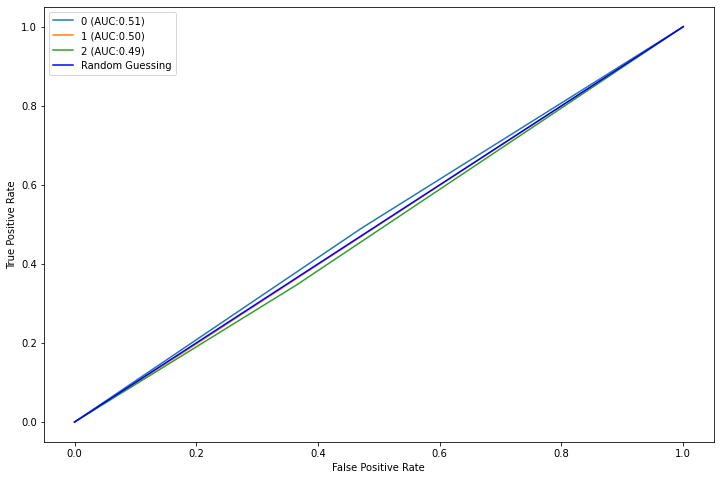

In [15]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= [0, 1, 2]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test1, all_pred1, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test1)
    y_test1 = lb.transform(y_test1)
    all_pred1 = lb.transform(all_pred1)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test1[:,idx].astype(int), all_pred1[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test1, all_pred1, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, all_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

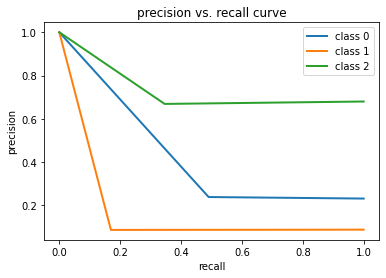

In [71]:
# precision recall curve
from sklearn.preprocessing import label_binarize

# Use label_binarize to be multi-label like settings
y = y_test.numpy()
Y = label_binarize(y, classes=[0, 1, 2])
Y_pred = label_binarize(all_pred, classes=[0, 1, 2])
n_classes = Y.shape[1]

precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i],
                                                        Y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

## Save the GPU CNN Model
Also includes loading on GPU

In [44]:
# Save GPU model
model_name = 'model_cnn.91821'
PATH = "/content/gdrive/MyDrive/Colab Notebooks/Models/{}".format(model_name)
torch.save(model.state_dict(), PATH)

In [ ]:
# Load GPU model
device = torch.device("cuda")
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)

In [ ]:
# Calculate a Confusion Matrix of all the data
train_preds = get_all_preds(model, train_loader)
preds_correct = get_num_correct(train_preds, y_train_tensor)
print("total correct: ", preds_correct)
print("Accuracy_p: ", (preds_correct/len(training_data))*100)

total correct:  27692
Accuracy_p:  67.39516658959819
